# MP3: Statistical Language Models

Hope McIntyre (hm7zg)

In [1]:
# Base
import numpy as np
import pandas as pd
import json
import re
import string
from os import listdir
import math
import timeit
import datetime

# Random
import random
random.seed()

# Natural Language Processing
import nltk
from nltk.stem.snowball import EnglishStemmer # load the stemmer module from NLTK
stemmer = EnglishStemmer() # Get an instance of SnowballStemmer for English

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from TM3_Methods import *

In [3]:
# Load Stopword List
stopwords = open('stopwords.txt', 'r').read().split()

In [4]:
# Get File Names for Test and Train set
files_test = listdir('yelp/test')
files_train = listdir('yelp/train')

In [5]:
dataDF_train = load_json(files_train, 'yelp/train/')
text_train = dataDF_train['Content']

reviewID_train = dataDF_train['ReviewID']
print("Num of rows: ",len(text_train))

Num of rows:  38688


In [6]:
dataDF_test = load_json(files_test, 'yelp/test/')
text_test = dataDF_test['Content']

reviewID_test = dataDF_test['ReviewID']
print("Num of rows: ",len(text_test))

Num of rows:  19803


In [133]:
# Combine Test and Train Datasets
dataDF = dataDF_train.append(dataDF_test)

In [356]:
len(dataDF.ReviewID), len(set(dataDF.ReviewID)) # 5000 Duplicate ReviewIDs

(58491, 53653)

In [8]:
# Combine Test and Train Content
text = text_train.append(text_test)

In [37]:
# Tokenize & Clean Corpus
tokens = [clean_words(i) for i in text]

In [38]:
# Remove Stopwords
tokens = [removeStopwords(i, stopwords) for i in tokens]

In [ ]:
dataDF[0:10]

In [135]:
# Define Binary Classification
dataDF['Class'] = 0
dataDF.ix[dataDF.Overall >= '4.0', 'Class'] = 1
dataDF[0:10]

,Author,Author_Location,Content,Date,Overall,ReviewID,Class
0,Kimberly M.,"La Verne, CA",We had our very last meal in N.O here and it w...,2014-07-14,5.0,oZM6XcKsYSiRoopkFDcmRA,1
1,Linda R.,"Los Angeles, CA",In short: this place was just alright. It def...,2014-07-17,3.0,TnQGrZk6g-rCgVU9V5oQ-A,0
2,Stacy F.,"La Mesa, CA",On a recommendation we came here for a birthda...,2014-07-16,4.0,kdL7ImCS9meCyHjk885riQ,1
3,Tracy B.,"Washington D.C., DC",This place was amazing! It's a little out of t...,2014-07-13,5.0,H7BH45EU_iw6d9wvNw0ZEA,1
4,Katie T.,"Lisle, IL",Fresh baked rolls are out of this world. Ham h...,2014-07-15,5.0,wi3zL1UgdbSWPbf4agTnXA,1
5,Marc H.,"St. Albans, NY",This place has enough positive reviews and I'm...,2014-07-16,5.0,noDtCmuOXsswGZKhMnoZFQ,1
6,Janelle R.,"San Francisco, CA",Honey! My meal was great! The swimming holeThe...,2014-07-05,5.0,RpiyxTwxusBJdNwjxTKFWw,1
7,Abby T.,"Dallas, TX","Any of their pork dishes are delicious, and th...",2014-07-14,4.0,sxGyxf0cMYDZZhhmXcyE-Q,1
8,Susan H.,"Sugar Land, TX","Three months ago, I had the distinct pleasure,...",2014-07-03,5.0,HoF9WNRGfcleoPLFQ5dG4g,1
9,Justin L.,"Memphis, TN","I was in New Orleans for business, and I was s...",2014-06-28,5.0,AxAiSxe5Ay5pmmA5AtKkEw,1


In [136]:
# Reset the index
dataDF = dataDF.reset_index()
del dataDF['index']

In [ ]:
dataDF[0:10]

## Task 1: Feature Selection

In [13]:
TF = getTermFreq(tokens)

In [14]:
DF = getDocFreq(tokens)

In [31]:
# Create list from DF with only Words with a DF of > 50
DF_50More = [k for k, v in DF.items() if v >= 50]

In [68]:
# Function to remove all words not in wordlist
def keepWords(text, wordList):
    newList = [t for t in text if t in wordList]
    return newList

In [ ]:
# Keep Only Words with >50 DF
tokens = [keepWords(i, DF_50More) for i in tokens]

In [ ]:
# Updated DF post Tail-Word removal
DF = getDocFreq(tokens)

### Information Gain Implementation

In [40]:
# Counts for Each Count Situation for Each Word
def getWordClassProbs_fast(dataDF, textlist):
    igWordProbs = {}
    total1 = len(dataDF[dataDF.Class == 1])
    total0 = len(dataDF[dataDF.Class == 0])
    
    for i in range(0,len(dataDF)):
        response = dataDF['Class'].iloc[i]
        tokenlist = set(textlist[i])
        
        for word in tokenlist:
            
            if word in igWordProbs:
                igWordProbs[word]['P'][response] += 1
                igWordProbs[word]['P_index'] = igWordProbs[word]['P_index']+[i]
            else:
                igWordProbs[word] = {}
                igWordProbs[word]['P'] = {}
                igWordProbs[word]['NP'] = {}
                igWordProbs[word]['P'][0] = 0
                igWordProbs[word]['P'][1] = 0
                igWordProbs[word]['P'][response] = 1
                igWordProbs[word]['P_index'] = [i]
            
    # Next Step is to Subset then Count and Update Dict for ['NP]
    for word in igWordProbs.keys():
        igWordProbs[word]['NP'][1] = total1 - igWordProbs[word]['P'][1]
        igWordProbs[word]['NP'][0] = total0 - igWordProbs[word]['P'][0]
    
    return(igWordProbs)

In [ ]:
# Get Counts of Class for Each Word in Corpus
igProbs = getWordClassProbs_fast(dataDF, tokens)

In [44]:
def calcEntropy(prob):
    if prob != 0: 
        return prob*math.log(prob) 
    else: 
        return float(0)

In [46]:
def calcInfoGain(word, dataDF, igWordClassProbs): 
    # print(word)
    obs = len(dataDF.ix[dataDF.Class])
    prob1 = len(dataDF.ix[dataDF.Class == 1])/obs
    prob0 = len(dataDF.ix[dataDF.Class == 0])/obs
    # print(obs, prob1, prob0)

    # If Word Present
    obsWord_P = igWordClassProbs[word]['P'][1] + igWordClassProbs[word]['P'][0]

    prob1GivenWordP = igWordClassProbs[word]['P'][1]/obsWord_P
    prob0GivenWordP = igWordClassProbs[word]['P'][0]/obsWord_P

    # If Word Not Present
    obsWord_NP = igWordClassProbs[word]['NP'][1] + igWordClassProbs[word]['NP'][0]

    prob1GivenWordNP = igWordClassProbs[word]['NP'][1]/obsWord_NP
    prob0GivenWordNP = igWordClassProbs[word]['NP'][0]/obsWord_NP
    
    pWord = sum(igWordClassProbs[word]['P'].values())/obs
    pNotWord = 1 - pWord

    infoGain = - (calcEntropy(prob1) + calcEntropy(prob0)) + \
        pWord * (calcEntropy(prob1GivenWordP) + calcEntropy(prob0GivenWordP)) + \
        pNotWord * (calcEntropy(prob1GivenWordNP) + calcEntropy(prob0GivenWordNP))
    
    return infoGain

In [48]:
igAll = {word: calcInfoGain(word, dataDF, igProbs) for word in DF_50More}

0:03:55.966742


### Top 20 words selected by Information Gain

In [57]:
igAllDF = pd.DataFrame.from_dict(igAll, orient = 'index')
igAllDF.columns = ['IG']
igAllDF = igAllDF.sort(columns = 'IG', ascending = False)
igAllDF[0:20]

,0
noth,0.010586
bland,0.009011
delici,0.008750
mediocr,0.008577
nt,0.008268
perfect,0.007817
decent,0.007607
rude,0.007508
amaz,0.007238
mayb,0.007229


### Chi Square Implementation

In [58]:
def calcChiSquared(word, igProbs):
    A = igProbs[word]['P'][1]
    B = igProbs[word]['NP'][1]
    C = igProbs[word]['P'][0]
    D = igProbs[word]['NP'][0]
    try: 
        X2 = ((A+B+C+D)*((A*D)-(B*C))**2) / ((A+C)*(B+D)*(A+B)*(C+D))
    except ZeroDivisionError:
        X2 = float(0)
    return X2

In [59]:
X2All = {word: calcChiSquared(word,igProbs) for word in DF_50More}

0:00:00.155619


### Top 20 words selected by Chi Square

In [60]:
X2_DF = pd.DataFrame.from_dict(X2All, orient = 'index')
X2_DF.columns = ['X2']
X2_DF = X2_DF.sort(columns = 'X2', ascending = False)
X2_DF[0:20]

,X2
noth,1455.300611
bland,1336.956776
mediocr,1284.126550
rude,1122.844041
decent,1069.719398
mayb,983.070359
bad,966.659487
nt,966.567879
overpr,924.687299
delici,916.983998


In [61]:
# Remove all Words/Features with X2 less then 3.841
X2All_features = X2_DF[X2_DF.X2 > 3.841]

### Size of your finalized controlled vocabulary after merging

In [66]:
# Merge InfoGain and Chi-Squared Features
features = list(set(igAllDF.index).intersection(set(X2All_features.index)))

1870

In [595]:
len(features)

1870

In [69]:
# Filter tokenized documents to only include features found from IG and X-Squared
tokens = [keepWords(text, features) for text in tokens]

### How many review documents are there in the resulting corpus after feature selection?

In [157]:
# Create New Data set and Token List of only Documents greater then 5 words.
dataDF_cont = dataDF
tokens_cont = []

for i in range(0,len(tokens)):
    # print(len(tokens[i]))
    if len(tokens[i]) < 5:
        dataDF_cont = dataDF_cont.drop(i)
    else:
        tokens_cont = tokens_cont+[tokens[i]]

0:01:57.748091


In [596]:
len(tokens_cont) # Note this number includes duplicates present in the original dataset

56258

In [325]:
# Reset Index for Dataframe
dataDF_cont = dataDF_cont.reset_index()
del dataDF_cont['index']

## Task 2: Naive Bayes

### 2.1 Training Naive Bayes with Maximum a Posterior estimator

In [180]:
# Get Index Locations for 1 and 0 Classes
indexIDs_1 = dataDF_cont.index[dataDF_cont.Class == 1]
indexIDs_0 = dataDF_cont.index[dataDF_cont.Class == 0]

In [181]:
# Make new list of all Reviews with Class 1 and 0 
tokens_1 = [tokens_cont[i] for i in indexIDs_1]
tokens_0 = [tokens_cont[i] for i in indexIDs_0]

In [182]:
# Make new list of all Reviews with Class 1
TF_1 = getTermFreq(tokens_1)
u_theta_1 = genUniLM(TF_1)

Total Probability:  1.0000000000000016


In [183]:
# Make new list of all Reviews with Class 0
TF_0 = getTermFreq(tokens_0)
u_theta_0 = genUniLM(TF_0)

Total Probability:  1.000000000000006


In [187]:
# createSmoothedProbability == Words in TF_1 and not in TF_0
pSmooth_1 = calc_pSmoothAdditive(list(TF_0.keys()), u_theta_1, 0.1)

In [192]:
# createSmoothedProbability == Words in TF_0 and not in TF_1
pSmooth_0 = calc_pSmoothAdditive(list(TF_1.keys()), u_theta_0, 0.1)

In [193]:
# Estimate Naive Bayes classifier
navBayes = {}
for word in TF_cont:
    logRatio = math.log(u_theta_1['p'].ix[word]/u_theta_0['p'].ix[word])
    navBayes[word] = logRatio

In [597]:
navBayesDF = pd.DataFrame.from_dict(navBayes, orient = "index")
navBayesDF.columns = ['logRatio']
navBayesDF = navBayesDF.sort('logRatio', ascending = False)

### List the top 20 word

In [198]:
navBayesDF[0:20]

,logRatio
flawless,3.548694
radic,3.041264
molecular,2.429462
gastronomi,2.364924
handsdown,2.313630
unforgett,2.307765
luscious,2.295931
unpretenti,2.240871
mmmmm,2.062316
scrumptious,2.002944


### List the bottom 20 word

In [199]:
navBayesDF[len(navBayesDF)-20:len(navBayesDF)]

,logRatio
inattent,-1.962043
horribl,-1.975672
undercook,-1.978044
meh,-1.984017
lacklust,-2.013808
arrog,-2.034803
bouncer,-2.061555
worst,-2.062360
rude,-2.119826
mediocr,-2.187307


### Q: Do they make sense to you in terms of distinguishing the positive opinion from negative opinion?

A: Yes, these seem to make a lot of sense in terms of differentiating between positive and negative reviews. Words like heaven and flawless are in the postive group and tasteless and meh are in the negative. The terms are very polarizing and have strong conotations with either good or bad.

### 2.2 Naive Bayes as a linear classifier

In [636]:
obs = len(dataDF_cont.ix[dataDF_cont.Class])
prob1 = len(dataDF_cont.ix[dataDF_cont.Class == 1])/obs
prob0 = len(dataDF_cont.ix[dataDF_cont.Class == 0])/obs
obs, prob1, prob0

(56258, 0.773969924277436, 0.2260300757225639)

In [637]:
def calcfX_NBLin(tokenlist, prob1, prob0, pSmooth_1, pSmooth_0):
    X = 0
    for word in tokenlist:
        x = math.log(pSmooth_1.ix[word])-math.log(pSmooth_0.ix[word])
        X = X + x
    fX = math.log(prob1/prob0) + X

    return fX

In [638]:
fX = [calcfX_NBLin(toks, prob1, prob0, pSmooth_1, pSmooth_0) for toks in tokens_cont]

In [639]:
# Sort documents with respect to fX in descending order
fXDF = pd.DataFrame({'fX': fX})
fXDF['df_index'] = range(0,len(fXDF))
fXDF['true'] = dataDF_cont.Class
fXDF = fXDF.sort(columns = 'fX', ascending = False)

In [640]:
# Calculate Precision/Recall metrics while varying threshold for the P/R Plot
mAll = []
for i in range(0,len(fXDF)):
    y_predicted = [1]*(i+1)+[0]*(len(fXDF)-1-i)
    m = calcPresionRecall(fXDF.true, y_predicted)
    mAll.append(m)

In [505]:
def calcPresionRecall(y_true, y_predicted):
    combo = pd.DataFrame({'true': y_true,'predicted': y_predicted})
    # nobs = len(combo)
    TP = len(combo[(combo.true == 1) & (combo.predicted == 1)])
    TN = len(combo[(combo.true == 0) & (combo.predicted == 0)])
    FP = len(combo[(combo.true == 0) & (combo.predicted == 1)])
    FN = len(combo[(combo.true == 1) & (combo.predicted == 0)])
    
    #TPR = truePos / (truePos + falseNeg) # Sensitivity
    #FPR = falsePos / (trueNeg + falsePos)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP+TN+FP+FN)
    
    metrics = (recall, precision, accuracy)
    return metrics

In [641]:
combo = list(zip(*mAll))

In [642]:
x = combo[0]
y = combo[1]

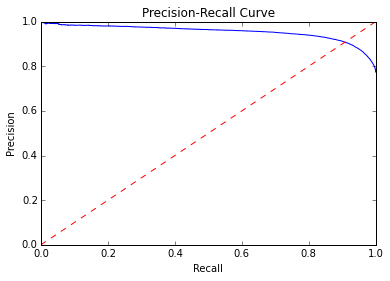

In [643]:
# Plot the Precision-Recall Graph - Take2
plt.title('Precision-Recall Curve')
plt.plot(x, y, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Q: Will we see different precision/recall tradeoffs (with alternate smoothing parameters)? Why?

A: No, we will not see a change because the controlled vocabulary greater limited the number of unseen words. Without a significant amount of unseen words the smoothed language model will not change greatly when the delta parameter is changed. If the probabilities in the language model do not change, the Naive Bayes classification will not change.

## Task 3: k Nearest Neighbor

In [323]:
# Build TF-IDF Vectors for all Documents
scaled_TFIDF = createScaledTFIDFvectors(tokens_cont, dataDF_cont)

56258 56258
51678
0:00:08.596800


### Random Projection Implemention

In [345]:
# Create Random Projection Vector
def createRandomVect(vocablist):
    vect = {}
    for word in vocablist:
        vect[word] = random.uniform(-1,1)
    return vect

In [346]:
# Create 5 Random Projections and Store Them
l = 5
vectors = {i: createRandomVect(list(DF_cont.keys())) for i in range(0,l)}

In [482]:
# Find Hash Bucket for Each Document
def buildHashMap(scaled_TFIDF, randomVectors):
    Hash = {}
    for review in scaled_TFIDF.keys():
        H = ''
        for i in range(0,len(randomVectors)): # For Each Random Vector
            dist = calc_dotProd(scaled_TFIDF[review], randomVectors[i]) # Need to Make into Dicts?
            if dist >= 0:
                h = 1
            else: h = 0

            H = H + str(h)

        if H in Hash:
            Hash[H] = Hash[H]+[review]
        else: 
            Hash[H] = [review]
    return Hash

In [363]:
def getHashCode(targetDoc, randomVectors): # Make sure TargetDoc a Dictionary of Words and TF-IDF
    H = ''
    for i in range(0,len(randomVectors)): # For Each Random Vector
        dist = calc_dotProd(targetDoc, randomVectors[i])
        if dist >= 0:
            h = 1
        else: h = 0
            
        H = H + str(h)
    return H

In [351]:
# Load Validation Documents
dataDF_val = load_json(['query.json'],'yelp/')
text_val = dataDF_val['Content']
# Define Binary Classification
dataDF_val['Class'] = 0
dataDF_val.ix[dataDF_val.Overall >= '4.0', 'Class'] = 1
dataDF_val[0:10]

,Author,Author_Location,Content,Date,Overall,ReviewID,Class
0,Cassie V.,"Chicago, IL","Ahhh tapas, the small plates that contain indi...",2014-05-20,4.0,C0XcD26vEKq0qiXddRG0uA,1
1,Tom,"Houston, TX",This was our last meal on our Chicago trip and...,2015-02-01,5.0,12345678901,1
2,Jack,"Houston, TX","My mouth is watering writing this review. Omg,...",2015-02-01,5.0,123456789012,1
3,Jack,"Houston, TX","In the basement of United Nations building, th...",2015-02-01,5.0,1234567890123,1
4,Patricia S.,"Houston, TX",I usually come here on friday or saturday nigh...,2014-06-18,4.0,12345678901234,1


In [357]:
# Tokenize and Reduce Validation Documents to Controlled Vocabulary
tokens_val = [clean_words(i) for i in text_val]
tokens_val = [keepWords(i, DF_50More) for i in tokens_val]

In [358]:
# Build TF-IDF Vectors for Validation Documents
scaled_TFIDF_val = createScaledTFIDFvectors(tokens_val, dataDF_val)

5 5
5


In [379]:
# Retrieve K Nearest Neighbors 
def getKNearestNeighbors(targetDoc, scaled_TFIDF, randomVectors, Hash, k):
    hashcode = getHashCode(targetDoc, randomVectors)
    distDict = {}
    if len(Hash[hashcode]) < k:
        print("Less than 5 documents in bucket")
        kNN = list(Hash[hashcode].values())
    else:
        for review in Hash[hashcode]:
            dist = calc_cosineDist(scaled_TFIDF[review], targetDoc)
            distDict[review] = dist
        distDF = pd.DataFrame.from_dict(distDict, orient = 'index')
        distDF.columns = ['cosSim']
        distDF = distDF.sort(columns = 'cosSim', ascending = False)
        kNN = list(distDF.index[0:5])
    return kNN

In [388]:
# Get kNN for Validation Documents
k = 5
kNN = {doc: getKNearestNeighbors(scaled_TFIDF_val[doc], scaled_TFIDF, vectors, Hash, k) for doc in list(dataDF_val.ReviewID)}

In [382]:
kNN

{'12345678901': ['9AfnjgED84IQ6tMoPw8fzg',
  'YQTvnK8l3icVBJD1J2FjBA',
  'BvI4f0m0D1bPUIy0Uzqkbw',
  'vrB_cTO9QB5d7xsrHhbn_A',
  'FUHe8kpJbZdieSOGkEvi6A'],
 '123456789012': ['c0vIJhNViWL6eHpeM0Dvmw',
  '7QSUEJ4imJW9ev2o7jJ3Sg',
  '7B1YbeAiX10Awhs3P298FA',
  '_AcdP5RbhabCQTtVYUsWcA',
  'SXd-Wcbbi-LR3w-dL5FvuQ'],
 '1234567890123': ['7DOxKTXeeNussrB9lYcjdg',
  'KQc1gr9Avuxs73dU2t7Heg',
  'EWVX3shpYMNsZS3LPj3QCQ',
  '1m3_dTM5L8mOKQdMGpLyMg',
  'ibUENbtGHLxApE9OUZnI6w'],
 '12345678901234': ['Vt6N0ZK8IyeuUzZR35-YRw',
  'u8shtB2n_DTgs4v-k8ArQA',
  'U5ewaF2kOJpWpVMQbFSnsA',
  'YoYcYL_rMTTnc_2FTdjOaA',
  'fX3RWMWQ8MN6W-Twli79dg'],
 'C0XcD26vEKq0qiXddRG0uA': ['cauGQT7TruxQp-yzxyyHJg',
  'Du7-KtWOVYzFSuiagLGySg',
  'oQ2UtCIakHH0cB1eXzwiZA',
  'fIdxy-6f3fIssmHSlF7uoQ',
  '-MHSt7UnvtLNgoUb4p2Tlg']}

### Report the running time for brute-force k nearest neighbor search

In [387]:
start = datetime.datetime.now()

distDict1 = {}
targetDoc = '12345678901'
for review in scaled_TFIDF.keys():
    dist = calc_cosineDist(scaled_TFIDF[review], scaled_TFIDF_val[targetDoc])
    distDict1[review] = dist
distDF = pd.DataFrame.from_dict(distDict1, orient = 'index')
distDF.columns = ['cosSim']
distDF = distDF.sort(columns = 'cosSim', ascending = False)
list(distDF.index[0:5])
        
runtime = datetime.datetime.now() - start
print(str(runtime))


0:00:04.545956


###  Report the running time for approximate k=5 nearest neighbor search by random projection

In [383]:
start = datetime.datetime.now()

targetDoc = '12345678901'
getKNearestNeighbors(scaled_TFIDF_val[targetDoc], scaled_TFIDF, vectors, Hash, k)

runtime = datetime.datetime.now() - start
print(str(runtime))

0:00:00.515837


### Q: Can we still find reasonable results with this approximation, i.e., does the retrieved documents help us determine the cuisine mentioned in the query document?

A: Yes, we can still get reasonable results from this approximation. As shown by the text of the nearest neighbors found using random project similar restuarant themes can be seen within the groups as was found in MP1. For example '12345678901' was mainly about tapas/sangria.

In [ ]:
# Print content of kNN for each document in the validation set.
pd.options.display.max_colwidth = 100
for review in kNN.keys():
    print('kNN for ReviewID: ', review)
    for N in kNN[review]:
        print(dataDF.Content[dataDF.ReviewID == N])
    print('\n')

## Task 4: Classification performance evaluation

In [407]:
dataDict = {dataDF_cont.loc[i,'ReviewID']: dataDF_cont.loc[i,'Class'] for i in range(0,len(dataDF_cont))}

In [550]:
tokensDict = {dataDF_cont.loc[i,'ReviewID']: tokens_cont[i] for i in range(0,len(dataDF_cont))}

In [574]:
# Create 10 Test/Train Splits
nbins = 10
shuffledIDs = np.array(list(dataDict.keys()))
random.shuffle(shuffledIDs)
binKey = np.array_split(shuffledIDs, nbins)

In [648]:
def getErrorType(truth,predicted):
    if truth == 1:
        if truth == predicted:
            return 'TP'
        else: return 'FN'
    if truth == 0:
        if truth == predicted:
            return 'TN'
        else: return 'FP'

In [649]:
def calcPresionRecallAcc(TP,TN,FP,FN):
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    # accuracy = (TP + TN) / (TP+TN+FP+FN)
    F1 = 2*((precision*recall)/(precision+recall))
    
    metrics = (recall, precision, F1)
    return metrics

### Report the average precision, recall and F1 measure of Naive Bayes over these 10-fold cross validation

In [ ]:
# Naive Bayes - 10 Fold Validation
nbins = 10
metricsNB = []
for i in range(0,nbins):
    # Hold out 1 Bin
    heldOut = i
    bins = range(0,10)
    trainBins = [x for x in bins if x != heldOut]
    
    # Get Review Ids for all Reviews in the non-heldout set
    trainIDs = []
    for x in trainBins:
        trainIDs = trainIDs + list(binKey[x])
        
    # Make Language Models 0 and 1 from Training Set Only
    # Make new list of all Reviews with Class 0
    ids_0 = [k for (k,v) in dataDict.items() if v == 0 and k in trainIDs]
    tokens_0 = [tokensDict[x] for x in ids_0]
    TF_0 = getTermFreq(tokens_0)
    u_theta_0 = genUniLM(TF_0)
    
    ids_1 = [k for (k,v) in dataDict.items() if v == 1 and k in trainIDs]
    tokens_1 = [tokensDict[x] for x in ids_1]
    TF_1 = getTermFreq(tokens_1)
    u_theta_1 = genUniLM(TF_1)
    
    # createSmoothedProbability == Words in TF_1 and not in TF_0
    pSmooth_0 = calc_pSmoothAdditive(list(TF_1.keys()), u_theta_0, 0.1)
    pSmooth_1 = calc_pSmoothAdditive(list(TF_0.keys()), u_theta_1, 0.1)

    # Testing
    # Test on Held Out Set
    
    predicted = {}
    true = {}
    accCounts = {'FN':0, 'TN':0, 'TP':0,'FP':0}
    
    prob0 = len(ids_0)/len(tokensDict)
    prob1 = len(ids_1)/len(tokensDict)
    for d in binKey[heldOut]:
        fX = calcfX_NBLin(tokensDict[d], prob1, prob0, pSmooth_1, pSmooth_0)
        if fX >= 0:
            predicted = 1
        else: predicted = 0

        truth = dataDict[d] # true class value in dataDict
        accCounts[getErrorType(truth,predicted)] +=1
    
    print(accCounts['TP'],accCounts['TN'],accCounts['FP'],accCounts['FN'])
    metrics = calcPresionRecallAcc(accCounts['TP'],accCounts['TN'],accCounts['FP'],accCounts['FN'])
 
    metricsNB = metricsNB + [metrics] 

In [646]:
x = [np.mean(x) for x in zip(*metricsNB)]
print("For NB - ",'precision: ',x[0], 'recall: ',x[1],'F1: ',x[2])

For NB -  precision:  0.903902738916 recall:  0.905403494481 F1:  0.904645875054


### Report the average precision, recall and F1 measure of kNN over these 10-fold cross validation

In [ ]:
# kNN
nbins = 10
randomVectors = vectors
metricskNN = []
for i in range(0,nbins):
    # Hold out 1 Bin
    heldOut = i
    bins = range(0,10)
    trainBins = [x for x in bins if x != heldOut]
    
    # Get Review Ids for all Reviews in the non-heldout set
    trainIDs = []
    for x in trainBins:
        trainIDs = trainIDs + list(binKey[x])
    
    # Filter TF-IDF dictionary to only in trainlist
    trainTFIDF = {ID: scaled_TFIDF[ID] for ID in trainIDs}
    trainHash = buildHashMap(trainTFIDF, randomVectors)

    # Testing
    predicted = {}
    true = {}
    accCounts = {'FN':0, 'TN':0, 'TP':0,'FP':0}
    for d in binKey[heldOut]:
        # print(targetdoc)
        kNN = getKNearestNeighbors(scaled_TFIDF[d], trainTFIDF, randomVectors, trainHash, k=5)
        
        # Majority Vote from Neighbors on Class
        pred = []
        for n in kNN:
            Class = dataDict[n]
            pred = pred + [Class]
        #predicted[targetDoc] = most_common(pred)
        #true[targetDoc] = dataDict_val[targetDoc] # true class value in dataDict
        
        predicted = most_common(pred)
        truth = dataDict[d] # true class value in dataDict
        accCounts[getErrorType(truth,predicted)] +=1
    
    print(accCounts['TP'],accCounts['TN'],accCounts['FP'],accCounts['FN'])
    metrics = calcPresionRecallAcc(accCounts['TP'],accCounts['TN'],accCounts['FP'],accCounts['FN'])
    metricskNN = metricskNN + [metrics] 

In [631]:
x = [np.mean(x) for x in zip(*metricskNN)]
print("For kNN - ",'precision: ',x[0], 'recall: ',x[1],'F1: ',x[2])

For kNN -  precision:  0.92526114765 recall:  0.801157984603 F1:  0.85873010189


### Perform paired two sample t-test to verify if one classifier is significantly better than another (set the confidence level to be 95%)?

In [623]:
def perform2sampleTtest(Y1, Y2, N1, N2, s1, s2, alpha):
    T = (Y1-Y2)/math.sqrt((s1**2/N1)+(s2**2/N2)) 

    # df = (N1 + N2) / 2 # if variances are assumed to be equal
    df = (((s1**2/N1)+(s2**2/N2))**2) / (((s1**2/N1)**2/(N1-1))+((s2**2/N2)**2/(N2-1)))

    # Assume two-tail test, t-statistic value

    t = stats.t.ppf(1-alpha/2, df)
    if abs(T) > t:
        print('Reject the null hypothesis that the two classifiers are equal')
    else:
        print('Do not reject the null')

In [647]:
# paired two sample t-test to verify if one classifier by F1 Score is significantly better than another 

from scipy import stats
alpha = 0.05 # 95%
N1 = 10 # Number of Folds
N2 = 10 # Number of Folds
s1 = [np.var(x) for x in zip(*metricsNB)][2]
s2 = [np.var(x) for x in zip(*metricskNN)][2]
Y1 = [np.mean(x) for x in zip(*metricsNB)][2]
Y2 = [np.mean(x) for x in zip(*metricskNN)][2]

# Perform t-test on Precision
perform2sampleTtest(Y1, Y2, N1, N2, s1, s2, alpha)

Reject the null hypothesis that the two classifiers are equal


It appears that one classifier is significantly better than the other according to the F1 score at 95% accuracy.

###  If so, which one is better?

It appears that the Naive Bayes performed better because it had a higher average F1-Score meaning a better average performance between precision and recall.

## Task 5: Explore the best configuration of l and k

### Experimental Design

To explore the best configuration of l and k I will use a grid search for the hyperparameter optimization. The grid will consist of all combinations of l and k between 3,6. The combinations are as follows: [(3, 3), (3, 4), (3, 5), (3, 6), (4, 3), (4, 4), (4, 5), (4, 6), (5, 3), (5, 4), (5, 5), (5, 6), (6, 3), (6, 4), (6, 5), (6, 6)].
Performance will be evaluated by F1 Score/runTime. Since 'l' will continue to improve F1 as the l decreases, but the computation time will increase dramactically the combined metric will allow for a quantiative evaluation of the trade-off. A smaller data set (test documents only) was used for the hyperparameter optimization to reduce runtime per cycle. It is assumed that this test set is representative of the whole sample and sufficiently large enough to evaluate the gain from different l,k parameters. Additionally, the hyperparameter optimization was completed on 4-fold validation set to again reduce runtime of each cycle, but maintain a representative evaluation of test error.

In [678]:
# Build search space, All combinations of 2 between 3 and 7.
import itertools
searchSpace = list(itertools.product(list(range(3,7)),list(range(3,7))))

In [661]:
# Create Test/Train Splits
nbins = 4
shuffledIDs = np.array(list(dataDict.keys()))
random.shuffle(shuffledIDs)
binKey = np.array_split(shuffledIDs, nbins)

In [662]:
def runkNNwithKNNandLVectors(nbins, l, k, dataDict = dataDict, DF_cont = DF_cont, scaled_TFIDF = scaled_TFIDF):    
    # Create l Random Projections and Store Them
    randomVectors = {i: createRandomVect(list(DF_cont.keys())) for i in range(0,l)}
    metricskNN = []
    for i in range(0,nbins):
        # Hold out 1 Bin
        heldOut = i
        bins = range(0,nbins)
        trainBins = [x for x in bins if x != heldOut]

        # Get Review Ids for all Reviews in the non-heldout set
        trainIDs = []
        for x in trainBins:
            trainIDs = trainIDs + list(binKey[x])

        # Filter TF-IDF dictionary to only in trainlist
        trainTFIDF = {ID: scaled_TFIDF[ID] for ID in trainIDs}
        trainHash = buildHashMap(trainTFIDF, randomVectors)

        # Testing
        predicted = {}
        true = {}
        accCounts = {'FN':0, 'TN':0, 'TP':0,'FP':0}
        for d in binKey[heldOut]:
            # print(targetdoc)
            kNN = getKNearestNeighbors(scaled_TFIDF[d], trainTFIDF, randomVectors, trainHash, k)

            # Majority Vote from Neighbors on Class
            pred = []
            for n in kNN:
                Class = dataDict[n]
                pred = pred + [Class]
            #predicted[targetDoc] = most_common(pred)
            #true[targetDoc] = dataDict_val[targetDoc] # true class value in dataDict

            predicted = most_common(pred)
            truth = dataDict[d] # true class value in dataDict
            accCounts[getErrorType(truth,predicted)] +=1

        print(accCounts['TP'],accCounts['TN'],accCounts['FP'],accCounts['FN'])
        metrics = calcPresionRecallAcc(accCounts['TP'],accCounts['TN'],accCounts['FP'],accCounts['FN'])
        metricskNN = metricskNN + [metrics]
    avgF1 = [np.mean(x) for x in zip(*metricskNN)][2]
    return avgF1

In [ ]:
# For tuple (l,k) in searchSpace set run kNN and store F1 metric in a dictionary

results = {}
for t in searchSpace:
    print(t)
    start = datetime.datetime.now()
    avgF1 = runkNNwithKNNandLVectors(nbins = 4, l=t[0], k=t[1])
    results[t] = avgF1
    runTime = datetime.datetime.now() - start
    print(str(runTime))

In [664]:
# Results of F1 from parameter optimization across search space, performed in another kernel (l, k)
resultsImport = {(3, 3): 0.88264620035319652,
 (3, 4): 0.8814689975823472,
 (3, 5): 0.8810198300108476,
 (3, 6): 0.88226383140147102,
 (4, 3): 0.87781495071839455,
 (4, 4): 0.8790340348342226,
 (4, 5): 0.87990170518039479,
 (4, 6): 0.87891960055827367,
 (5, 3): 0.87707545799950171,
 (5, 4): 0.87685527336127533,
 (5, 5): 0.87156628390704527,
 (5, 6): 0.87421291008395519,
 (6, 3): 0.87472004232895384,
 (6, 4): 0.87205083473488654,
 (6, 5): 0.87239442261958666,
 (6, 6): 0.87228927197866557}

In [668]:
# Finds optimal l,k combination within search space by F1 Score only
max_F1 = max(resultsImport.values())             #finds the max value
max_keys = [k for k,v in resultsImport.items() if v == max_F1]
max_keys

[(3, 3)]

To find runtime, runtimes from one cycle of each value of l with k constant (k=5) was used as an estimate for runtime with l at that parameter value. Values of runtime were round to the nearest minute.

(3, 5) - 0:14:51.478454
(4, 5) - 0:07:22.174533
(5, 5) - 0:04:02.294308
(6, 5) - 0:02:39.817204

In [672]:
runtimeImport = {3: 15,
4: 7,
5: 4,
6: 3}

In [ ]:
# Finds optimal l,k combination within search space by F1 Score / runTime
finalScore = {}
for t in resultsImport.keys():
    print(t)
    finalScore[t] = resultsImport[t]/runtimeImport[t[0]]

In [677]:
max_score = max(finalScore.values())             #finds the max value
max_score_keys = [k for k,v in finalScore.items() if v == max_score]
max_score_keys

[(6, 3)]

By the metric factoring in runtime, the optimal l,k parameter within my searchspace would be l=6 and k=3. Given this result I would likely extend my searchspace to continue evaluating several additional larger l values (i.e. l=7,8). But given this search and experiment design (l,k) of (6,3) would be my choice.